In [1]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! mkdir Data

In [ ]:
! kaggle datasets list

In [7]:
! kaggle competitions download -c 'histopathologic-cancer-detection'

100% 6.31G/6.31G [05:11<00:00, 22.9MB/s]
100% 6.31G/6.31G [05:11<00:00, 21.7MB/s]


In [ ]:
! unzip histopathologic-cancer-detection.zip -d Data

# Histopathologic Cancer Detection
## Week 3 - Introduction to Deep Learning

In [9]:
import cv2
import gc
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns
import os
import pandas as pd
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

Structure the dataset

In [10]:
# Defining key initial paths
path = "Data/"
train_path = path + "train/"
test_path = path + "test/"

# Stitching togehter the df
offset = len(path + "train/")
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df['id'] = df['path'].map(lambda x: str(x)[offset:-4])
labels = pd.read_csv(path+"train_labels.csv")
df = df.merge(labels, on = "id")
df['filename'] = df['path'].map(lambda x: str(x)[len(train_path):])


## Exploratory Data Analysis

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220025 entries, 0 to 220024
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   path      220025 non-null  object
 1   id        220025 non-null  object
 2   label     220025 non-null  int64 
 3   filename  220025 non-null  object
dtypes: int64(1), object(3)
memory usage: 8.4+ MB


In [12]:
df.head()

,path,id,label,filename
0,Data/train/2610b65dc244f3952010df9376b1fab995e...,2610b65dc244f3952010df9376b1fab995e7a65b,1,2610b65dc244f3952010df9376b1fab995e7a65b.tif
1,Data/train/2fb93a0b2d73b0506af9f629b93854ae203...,2fb93a0b2d73b0506af9f629b93854ae203a3892,0,2fb93a0b2d73b0506af9f629b93854ae203a3892.tif
2,Data/train/3f376ce523ac1a2b9b06344e99176406a5c...,3f376ce523ac1a2b9b06344e99176406a5cf856d,1,3f376ce523ac1a2b9b06344e99176406a5cf856d.tif
3,Data/train/0751c1abbe4be655d42de68c75fcae91f3b...,0751c1abbe4be655d42de68c75fcae91f3b1e5ca,0,0751c1abbe4be655d42de68c75fcae91f3b1e5ca.tif
4,Data/train/be6c856254c2d5881d3b4bdf21c2300bde8...,be6c856254c2d5881d3b4bdf21c2300bde839954,1,be6c856254c2d5881d3b4bdf21c2300bde839954.tif


The training set is populated with 220025 files, structured as 'path', 'id', 'label' and 'filename'

From the Kaggle website we already know that there is no need to check for NaN and duplicates since those have already been handled. We also know that each image is 96x96x3

In [13]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

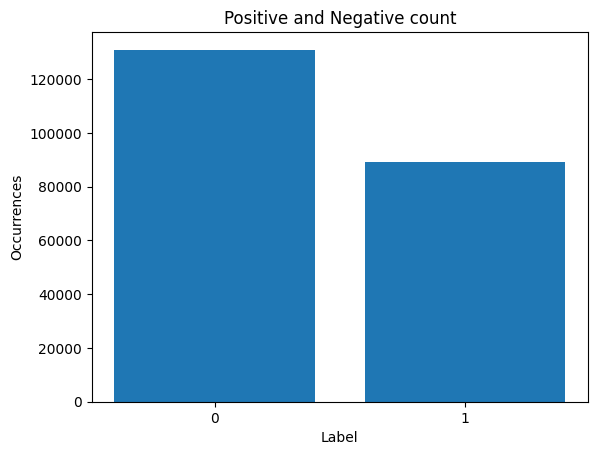

In [14]:
label_counts = df['label'].value_counts()

# Plotting the occurrences
plt.bar(label_counts.index, label_counts.values, tick_label=label_counts.index)
plt.xlabel('Label')
plt.ylabel('Occurrences')
plt.title('Positive and Negative count')
plt.show()

There is a little impairment in the value counts, with about 60% of negative samples

In [15]:
# In new update binary classification requires strings not ints
df['label'] = df['label'].astype(str)

747ac25369951e00f4a8e295b3b79875b659bb85
b24f2d79d5b0ee2c6e108e91ce77026aebb978b9
f85bf5ea2051b22e895a6ff7835d6c9c0900f01f
f3d1d217d47b9ec3827800069559d1589a542a47
c29a055e841298fd022e266727512b303325baca


Text(0, 0.5, 'Tumor tissue samples')

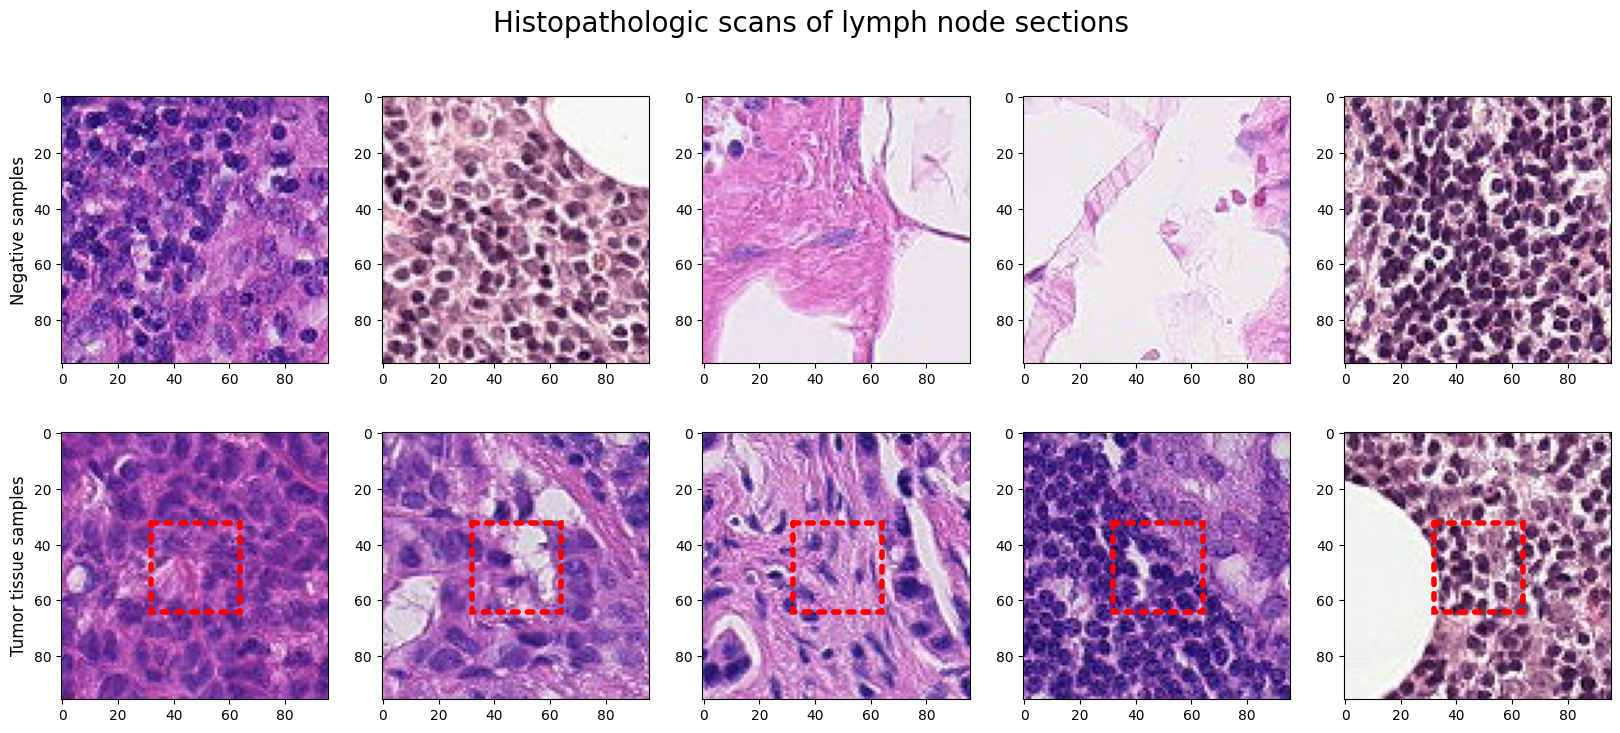

In [16]:
from sklearn.utils import shuffle
shuffled_data = shuffle(df)

def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img


fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)

# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == '0']['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
ax[0,0].set_ylabel('Negative samples', size='large')

# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == '1']['id'][:5]):
    path = os.path.join(train_path, idx)
    print(idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')


The red box highlight the tumor. In the samples with label '1', we know that at least one pixel in the central 32x32 square is part of tumor tissue

## Data Preparation

We split the data in training and validation set

In [17]:
df_train, df_val = train_test_split(df, test_size=0.10, random_state=42, stratify=df['label'])
dimensions = cv2.imread(df_train['path'][0]).shape
print(dimensions)

(96, 96, 3)


In [18]:
datagen = ImageDataGenerator(rescale=1./255)

# Want generators for both training and validation set
train_gen = datagen.flow_from_dataframe(df_train,
                                        directory="Data/train/",
                                        x_col='filename',
                                        y_col='label',
                                        target_size=(96, 96),
                                        class_mode='binary',
                                        batch_size=32,
                                        shuffle=False)

val_gen = datagen.flow_from_dataframe(df_val,
                                    directory="Data/train/",
                                    x_col='filename',
                                    y_col='label',
                                    target_size=(96, 96),
                                    class_mode='binary',
                                    batch_size=32,
                                    shuffle=False)

Found 198022 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.


## CNN Model
The model choose for the classification task is made up by 5 layers. Each of them consist of a convolutional network with a 3x3 filter and a maxpooling layer with a 2x2 filter.
The activation function used is ReLu, one of the most common and reccomended for convergence.The output filter on the other hand uses a sigmoid function since the binary classification task

In [19]:
filter_size = (3,3)
pool_size = (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_dense = 0.5

model = Sequential()
# Layer 1: Input Layer
model.add(Conv2D(first_filters, filter_size, activation='relu',input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size))
# Layer 2
model.add(Conv2D(second_filters, filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size))
# Layer 3
model.add(Conv2D(third_filters, filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size))
# Layer 4
model.add(Conv2D(third_filters, filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size))
# Layer 5: Output Layer
model.add(Flatten())
model.add(Dropout(dropout_dense))  #Dropout for regularization
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print("Model Built")
model.summary()

Model Built
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 

The model implement Adam optimizer, widely reccomended online, a control on the learing rate, and an early stopping if the model loss on the validation set stop improving


In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Training CNN
train_sample = len(df_train)
val_sample = len(df_val)
batch_size = 100

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_loss',
                     min_delta=0,
                     patience=2,
                     verbose=1,
                     mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)

callbacks_list = [checkpoint, early, reduce_lr]

In [22]:
history = model.fit(train_gen,
                         steps_per_epoch= np.ceil(train_sample / batch_size),
                         epochs=10,
                         validation_data=val_gen,
                         validation_steps=np.ceil(val_sample / batch_size),
                         callbacks=callbacks_list)


Epoch 1/10
1981/1981 [==============================] - ETA: 0s - loss: 0.4708 - accuracy: 0.7830
Epoch 1: val_accuracy improved from -inf to 0.81604, saving model to model.h5
1981/1981 [==============================] - 195s 93ms/step - loss: 0.4708 - accuracy: 0.7830 - val_loss: 0.4223 - val_accuracy: 0.8160 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
1981/1981 [==============================] - ETA: 0s - loss: 0.3909 - accuracy: 0.8291
Epoch 2: val_accuracy improved from 0.81604 to 0.83145, saving model to model.h5
1981/1981 [==============================] - 137s 69ms/step - loss: 0.3909 - accuracy: 0.8291 - val_loss: 0.3684 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 3/10
1981/1981 [==============================] - ETA: 0s - loss: 0.3528 - accuracy: 0.8482
Epoch 3: val_accuracy did not improve from 0.83145
1981/1981 [==============================] - 127s 64ms/step - loss: 0.3528 - accuracy: 0.8482 - val_loss: 0.3782 - val_accuracy: 0.8191 - lr: 0.0010
Epoch 4/10
1981/1981 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.8600
Epoch 4: val_accuracy improved from 0.83145 to 0.86609, saving model to model.h5
1981/1981 [==============================] - 110s 56ms/step - loss: 0.3288 - accuracy: 0.8600 - val_loss: 0.3175 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 5/10
1981/1981 [========================

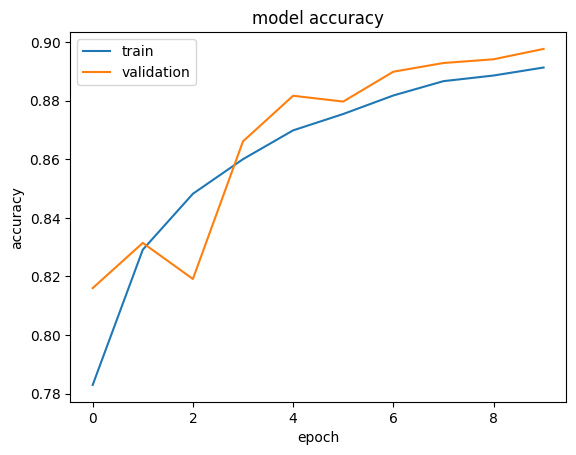

<Figure size 640x480 with 0 Axes>

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

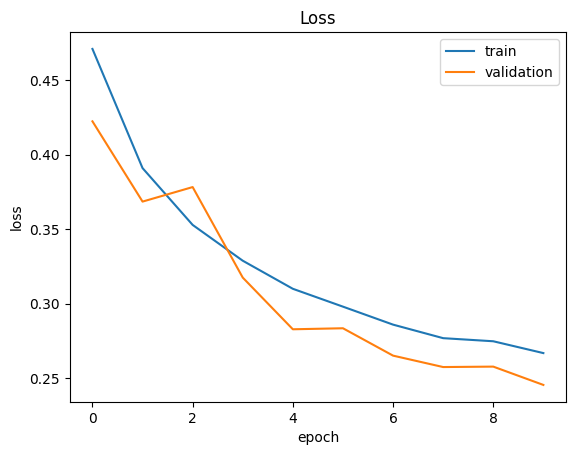

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [29]:
print("The accuracy on the training set is: ", history.history['accuracy'][-1])
print("The accuracy on the validation set is: ",history.history['val_accuracy'][-1])

The accuracy on the training set is:  0.8912823796272278
The accuracy on the validation set is:  0.8976244330406189


## Results

The model reached a 89.3% accuracy on the validation set and a 89.7% accuracy on the training set, so the model is able to generalize and doesn't overfit the training data.
The Coursera course did not set a threshold on the performance neither asked for the best achievable model, so the accuracy of the CNN was not further analysed, but using a more complex model it should be possible to reach both a better accuracy and performance

### Kaggle submission file
Prediction on test set and preparation of a .csv file for Kaggle competition

In [24]:
# Predicting the outcome on the testing set
df_test = pd.DataFrame({'path': glob(os.path.join(test_path,'*.tif'))})
df_test['filename'] = df_test['path'].map(lambda x: str(x)[len(test_path):])
df_test['id'] = df_test['path'].map(lambda x: str(x)[len(test_path):-4])
datagen = ImageDataGenerator(rescale=1./255)
test_gen = datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = test_path,
    target_size = (96, 96),
    shuffle=False,
    batch_size=1,
    class_mode = None)

pred = model.predict(test_gen, verbose=1)


Found 57458 validated image filenames.
57458/57458 [==============================] - 188s 3ms/step


In [25]:
# Compiling the results into a submission csv
#submission = pd.DataFrame()
#submission['id'] = df_test['id']
#submission['label'] = np.round(pred)
#submission['label'] = submission['label'].astype(int)
#submission.head()
#submission.to_csv("submission.csv",index=False)
